# INDEX

-  [MODELING, loadING, EVOLVING](#modeling-loading-evolving)

    1. [Modeling](#modeling)

    2. [loading](#loading)

    3. [Evolving](#evolving)

- [QUERYING](#querying)
    
    1. [Query 1](#query-1:-find-the-top-3-most-cited-papers-of-each-conference.)

    2. [Query 2](#query-2:-for-each-conference-find-its-community:-i.e.,-those-authors-that-have-published-papers-on-that-conference-in,-at-least,-4-different-editions.)

    3. [Query 3](#query-3:-find-the-impact-factors-of-the-journals-in-your-graph.)

    4. [Query 4](#query-4:-find-the-h-indexes-of-the-authors-in-your-graph.)

# IMPORTS

In [1]:
# If needed:
# !pip install pillow #(not necessary if only opening the graph images)
# !pip install faker
# !pip install uuid
# !pip install neo4j

In [2]:
from faker import Faker
import random
import uuid
import json
import pandas as pd
from neo4j import GraphDatabase, basic_auth
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
from PIL import Image
from IPython.display import display

In [3]:
def int_to_roman(num):
    if not (isinstance(num, int) or isinstance(num, float)):
        raise TypeError("Input must be an integer or float")
    
    num = int(round(num, 0))
    
    if not (1 <=  num <=  50):
        raise ValueError("Number out of range (must be between 1 and 50)")
    
    val = [
        50, 40, 10, 9, 5, 4, 1
    ]
    syb = [
        "L", "XL", "X", "IX", "V", "IV", "I"
    ]
    roman_num = ''
    i = 0
    while  num > 0:
        for _ in range(num // val[i]):
            roman_num +=  syb[i]
            num -=  val[i]
        i +=  1
    return roman_num

In [5]:
uri = input('URI: Enter a value for the URI (default is "bolt://localhost:7687")')
if not uri:
    uri = "bolt://localhost:7687"

user = input('Username: Enter a value for the username (default is "neo4j")')
if not user:
    user = "neo4j"

password = input('Password: Enter a value for the password (NO DEFAULT VALUE)')

driver = GraphDatabase.driver(uri, auth = (user, password))

In [6]:
pathname_import = input('Enter a path to the import folder (NO DEFAULT VALUE)')

# MODELING, LOADING, EVOLVING

[Back to Index](#INDEX)

## Modeling

[Back to Index](#INDEX)

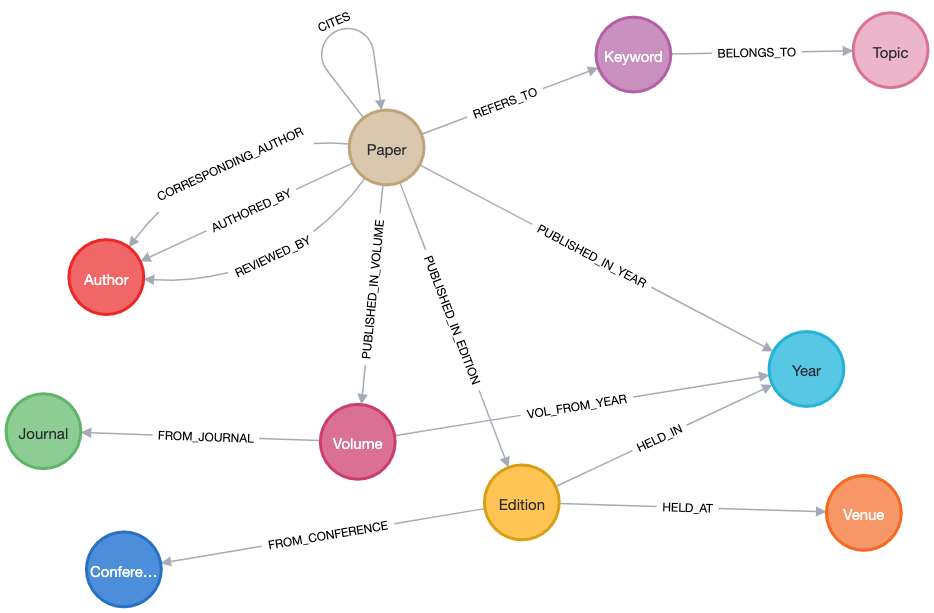

In [7]:
# img = Image.open('graphA1.png')
# background = Image.new('RGBA', img.size, (255, 255, 255, 255))
# background.paste(img, (0, 0), img)
# background = background.convert('RGB')
# background.save('graphA1_white_bg.png')

display(Image.open('graphA1_white_bg.png'))

Additionally to the nodes and relationships, we have additional attributes, as follows:
- Paper: Title, abstract, number of pages, year of publication (which coincides with the year of the conference or journal in which it was published), DOI number.
- Author: Name, affiliation.
- Keyword: Keyword.
- Topic: Topic name.
- Conference: General name of the conference.
- Journal: Name of the journal.
- Edition: Edition full name (with number), number of attendees, location/venue, number of pages of the proceedings for the specific edition (which is the sum of the pages of all the papers in that edition).
- Volume: Volume number, year of publication, number of pages of the volume (which is the sum of the pages of all the papers in that volume).
- Year: Year number.
- Venue: Name of the venue (all major cities in the world).

The configuration we created relates each paper to its authors, corresponding authors and to its reviewers (with different relations). This way, we can easily query for all the people who participated in the publication of the paper. We also relate each paper with the other papers it cites to allow for smooth querying of number of references between papers. Finally, if anyone is interested in getting information about the citations of a paper, we can easily query for it using our configuration. Each keyword is additionally related to the topic to which it refers, in order to allow for easy querying for the topics of each paper.
We relate each paper to either the volume of a journal or the edition of a conference/workshop in which it was published. This way, it's fast to query for papers published in each edition or volume or even to know which authors published in each one of those. We can also easily query for the amount of papers published by an author in a given journal because we also relate each edition to their specific conference/workshop and each volume to the journal it belongs to (instead of storing this type of information inside of the attributes of each edition/volume, case in which the querying would be slower and less efficient). 
Finally, information about the year of publication of a volume/edition and the city in which a conference/workshop took place is also stored in the database using separate nodes and relations for each. This way, we can effortlessly relate which topics have been talked about in a given city or which authors published in a given year. 

We used this configuration of the database to ensure maximum that enough nodes were created so that additional information can be related to the database. For example, it could have been easier to just store information about the year of publication of the volumes and Editions' proceedings as attributes to each node but this would have made it harder afterwards to add new nodes which might need to also be related to years. Maybe we could need to include a relation about the year when a topic was first introduced. In this case, it would be very easy as we just need to create the relation from each topic to their respective year.

Non-essential information is included only as attributes so even if we don't know the exact number of attendees for a given edition, we can still enter the rest of the information about that edition without needing to create a low confidence relation from it which would show in the queries.

Regarding part B, we can easily count the amount of citations of the papers of each conference, we can also easily count the amount of times that each author appears as the author of papers published in a given conference. We can also pretty easily get the total amount of citations received by the papers published in a given journal and the amount of papers published there as well. Regarding the h-index, it is even easier as we can very easily relate the papers to each author and count their citations in order to compute the h-index.

## Loading

[Back to Index](#INDEX)

In [8]:
random.seed(168)

faker = Faker()
Faker.seed(168)

num_companies = 15
num_authors = 200
num_papers = 1000
num_conferences = 5
num_journals = 4
num_topics = 10
num_keywords = 50
num_reviews_per_paper = 3
num_venues = 20
num_years = 50

In [9]:
# Generate Institutions
institutions = [{"name": faker.company()} for _ in range(num_companies)]

# Generate Authors
unique_names = []
while len(unique_names) < num_authors:
    name = faker.name()
    if name not in unique_names:
        unique_names.append(name)

authors = []
for name in unique_names:
    auth = {
        "name": name,
        "affiliation": random.choice(institutions)["name"]
    }
    authors.append(auth)


# Generate Topics and Keywords
topics = [{"topic": topic} for topic in [
    "Machine Learning",
    "Natural Language Processing",
    "Computer Vision",
    "Reinforcement Learning",
    "Robotics",
    "Data Mining",
    "Database Management",
    "Neural Networks",
    "Time-Series Analysis",
    "Software Engineering"
]]

keywords = []
for topic in topics:
    for _ in range(5):
        keywords.append({"word": faker.word(), "topic": topic["topic"]})

# Generate Venues
cities = [
    "New York",
    "London",
    "Tokyo",
    "Paris",
    "Sydney",
    "Toronto",
    "Berlin",
    "Singapore",
    "Hong Kong",
    "Dubai",
    "Los Angeles",
    "Barcelona",
    "Moscow",
    "São Paulo",
    "Johannesburg",
    "Rome",
    "Istanbul",
    "Beijing",
    "Mumbai",
    "Buenos Aires"
]

venues = [{"city": city} for city in cities]

# Generate Years
years = [{"year": str(year)} for year in range(2024 - num_years, 2024)]

# Generate Papers
papers = []
for _ in range(num_papers):
    num_authors_per_paper = random.randint(2, 5)
    list_of_authors_names = [author["name"] for author in authors]
    author_list = random.sample(list_of_authors_names  , k = num_authors_per_paper)
    corresponding_author = random.choice(author_list)
    author_list.remove(corresponding_author)
    num_keywords_per_paper = random.randint(3, 7)
    keyword_list = random.sample(keywords, k = num_keywords_per_paper)
    
    # list_of_years = [year["year"] for year in years]
    # year_paper = random.choice(list_of_years)
    
    # prefix = "https://doi.org/"
    # directory = random.randint(10, 99)
    # journal_number = random.randint(1000000, 9999999)
    # article_number = random.randint(1000000, 9999999)
    
    paper = {
        "title": faker.sentence(nb_words = 6),
        "abstract": faker.paragraph(nb_sentences = 5),
        # "year": year_paper,
        "pages": random.randint(5, 35),
        # "DOI": f"{prefix}{directory}.{journal_number}.{year_paper}.{article_number}",
        "authors": author_list,
        "corresponding_author": corresponding_author,
        "keywords": keyword_list
    }
    papers.append(paper)

# Generate Conferences and Editions
conferences = [{"name": f"Conference of {faker.word()}"} for _ in range(num_conferences)]

editions = []
for conf in conferences:
    num_editions = random.randint(4, 8)
    starting_year = random.randint(1990, 1974 + num_years - num_editions)
    for i in range(num_editions):
        edition = {
            "conference_name": conf["name"],
            "edition_name": f"{conf["name"]} {int_to_roman(i + 1)}",
            "attendees": random.randint(100, 1000),
            "venue": random.choice(venues)["city"],
            "year": str(starting_year + i),
            "proceedings_pages": 0
        }
        editions.append(edition)

# Generate Journals and Volumes
journals = [{"name": f"Journal of {faker.word()}"} for _ in range(num_journals)]

volumes = []
for journal in journals:
    num_volumes = random.randint(3, 7)
    starting_year = random.randint(1990, 1974 + num_years - num_volumes)
    for i in range(num_volumes):
        volume = {
            "journal_name": journal["name"],
            "volume_number": f"{journal["name"]} vol. {int_to_roman(i + 1)}",
            "year": str(starting_year + i),
            "volume_pages": 0
        }
        volumes.append(volume)

# Assign Papers to editions or volumes
containers = editions + volumes
random.shuffle(containers)
num_containers = len(containers)
container_papers = {i: [] for i in range(num_containers)}

for i, paper in enumerate(papers):
    container_index = i % num_containers
    container = containers[container_index]
    container_papers[container_index].append(paper)
    paper["year"] = container["year"]
    
    prefix = "https://doi.org/"
    directory = random.randint(10, 99)
    journal_number = random.randint(1000000, 9999999)
    article_number = random.randint(1000000, 9999999)
    
    paper["DOI"] = f"{prefix}{directory}.{journal_number}.{paper["year"]}.{article_number}"
    
    if "conference_name" in container:
        paper["published_in"] = container["edition_name"]
    else:
        paper["published_in"] = container["volume_number"]

for container_index, p in container_papers.items():
    container = containers[container_index]
    total_pages = sum(paper["pages"] for paper in p)
    if "conference_name" in container:
        container["proceedings_pages"] = total_pages
    else:
        container["volume_pages"] = total_pages

# Generate Reviews as Relationships
reviews = []
for paper in papers:
    eligible_reviewers = [author for author in authors if author["name"] not in paper["authors"]]
    reviewers = random.sample(eligible_reviewers, k = num_reviews_per_paper)
    for reviewer in reviewers:
        review = {
            "paper_DOI": paper["DOI"],
            "reviewer_name": reviewer["name"]
        }
        reviews.append(review)

# Generate Citations for the Papers 
for paper in papers:
    num_citations = random.randint(5, 15)
    eligible_papers = [p for p in papers if p["DOI"] !=  paper["DOI"]]
    citations = random.sample(eligible_papers, k = num_citations)
    paper["citations"] = [citation["DOI"] for citation in citations]

# Generate Reviews as Nodes
node_reviews = []

for paper in papers:
    paper_doi = paper["DOI"]
    paper_authors = paper["authors"]
    paper_authors.append(paper["corresponding_author"])
    if random.random() < 0.5:
        decisions = ["positive", "positive", "negative"]
    else:
        decisions = ["positive", "positive", "positive"]
    eligible_reviewers = [author for author in authors if author["name"] not in paper_authors]
    for decision in decisions:
        reviewer = random.choice(eligible_reviewers)
        eligible_reviewers.remove(reviewer)
        review = {
            "review_id": str(uuid.uuid4()),
            "content": faker.paragraph(nb_sentences = 10),
            "decision": decision,
            "reviewer_name": reviewer["name"],
            "paper_doi": paper_doi
        }
        node_reviews.append(review)

In [10]:
data = {
    "institutions": institutions,
    "authors": authors,
    "papers": papers,
    "conferences": conferences,
    "editions": editions,
    "journals": journals,
    "volumes": volumes,
    "keywords": keywords,
    "topics": topics,
    "reviews": reviews,
    "venues": venues,
    "years": years,
    "node_reviews": node_reviews
}

# Save to json file for safekeeping
with open("faked_data.json", "w") as f:
    json.dump(data, f, indent = 4)

print("Faked data generated and saved to faked_data.json")

Faked data generated and saved to faked_data.json


In [11]:
""" we convert the json file to csv and we store it in the folder of the imports for the neo4j database """

# Save institutions
pd.DataFrame(data['institutions']).to_csv(f'{pathname_import}/institutions.csv', index = False)

# Save authors
pd.DataFrame(data['authors']).to_csv(f'{pathname_import}/authors.csv', index = False)

# Save topics
pd.DataFrame(data['topics']).to_csv(f'{pathname_import}/topics.csv', index = False)

# Save keywords
df_keywords = pd.DataFrame(data['keywords'])
df_keywords.to_csv(f'{pathname_import}/keywords.csv', index = False)

# Save venues
pd.DataFrame(data['venues']).to_csv(f'{pathname_import}/venues.csv', index = False)

# Save years
df_years = pd.DataFrame(data['years'])
df_years['year'] = df_years['year'].astype(int)
df_years.to_csv(f'{pathname_import}/years.csv', index = False)

# Save papers
df_papers = pd.DataFrame(data['papers'])
df_papers['pages'] = df_papers['pages'].astype(int)
df_papers['year'] = df_papers['year'].astype(int)
df_papers.to_csv(f'{pathname_import}/papers.csv', index = False)

# Save paper authors
paper_authors = []
for paper in data['papers']:
    for author in paper['authors']:
        paper_authors.append({'DOI': paper['DOI'], 'author_name': author})
pd.DataFrame(paper_authors).to_csv(f'{pathname_import}/paper_authors.csv', index = False)

# Save paper publications
paper_editions = []
paper_volumes = []
for paper in data['papers']:
    if 'Conference' in paper['published_in']:
        paper_editions.append({'DOI': paper['DOI'], 'edition': paper['published_in']})
    else:
        paper_volumes.append({'DOI': paper['DOI'], 'volume': paper['published_in']})
pd.DataFrame(paper_editions).to_csv(f'{pathname_import}/paper_editions.csv', index = False)
pd.DataFrame(paper_volumes).to_csv(f'{pathname_import}/paper_volumes.csv', index = False)

# Save paper citations
paper_citations = []
for paper in data['papers']:
    for citation in paper['citations']:
        paper_citations.append({'DOI': paper['DOI'], 'cited_DOI': citation})
pd.DataFrame(paper_citations).to_csv(f'{pathname_import}/paper_citations.csv', index = False)

# paper_corresponding_authors = []
# for paper in data['papers']:
#     paper_corresponding_authors.append({'DOI': paper['DOI'], 'corresponding_author': paper['corresponding_author']})
# pd.DataFrame(paper_corresponding_authors).to_csv(f'{pathname_import}/paper_corresponding_authors.csv', index = False)

# Save paper keywords
paper_keywords = []
for paper in data['papers']:
    for keyword in paper['keywords']:
        paper_keywords.append({'DOI': paper['DOI'], 'keyword': keyword['word']})
pd.DataFrame(paper_keywords).to_csv(f'{pathname_import}/paper_keywords.csv', index = False)

# Save conferences
pd.DataFrame(data['conferences']).to_csv(f'{pathname_import}/conferences.csv', index = False)

# Save editions
df_editions = pd.DataFrame(data['editions'])
df_editions['year'] = df_editions['year'].astype(int)
df_editions['attendees'] = df_editions['attendees'].astype(int)
df_editions['proceedings_pages'] = df_editions['proceedings_pages'].astype(int)
df_editions.to_csv(f'{pathname_import}/editions.csv', index = False)

# Save journals
pd.DataFrame(data['journals']).to_csv(f'{pathname_import}/journals.csv', index = False)

# Save volumes
df_volumes = pd.DataFrame(data['volumes'])
df_volumes['year'] = df_volumes['year'].astype(int)
df_volumes['volume_pages'] = df_volumes['volume_pages'].astype(int)
df_volumes.to_csv(f'{pathname_import}/volumes.csv', index = False)

# Save reviews
df_reviews = pd.DataFrame(data['reviews'])
df_reviews.to_csv(f'{pathname_import}/reviews.csv', index = False)

# Save node reviews
df_nodereviews = pd.DataFrame(data['node_reviews'])
df_nodereviews.to_csv(f'{pathname_import}/node_reviews.csv', index = False)

In [12]:
def clear_database(tx):
    tx.run("MATCH (n) DETACH DELETE n")

def load_data(tx):
    # Load Authors
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///authors.csv' AS row
    CREATE (:Author {author_name: row.name});
    """)

    # Load Topics
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///topics.csv' AS row
    CREATE (:Topic {topic: row.topic});
    """)

    # Load Keywords
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///keywords.csv' AS row
    MATCH (t:Topic {topic: row.topic})
    CREATE (k:Keyword {keyword: row.word})-[:BELONGS_TO]->(t);
    """)

    # Load Venues
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///venues.csv' AS row
    CREATE (:Venue {city: row.city});
    """)

    # Load Years
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///years.csv' AS row
    CREATE (:Year {year: row.year});
    """)
    
    # Load Conferences
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///conferences.csv' AS row
    CREATE (:Conference {conference_name: row.name});
    """)

    # Load Journals
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///journals.csv' AS row
    CREATE (:Journal {journal_name: row.name});
    """)

    # Load Editions
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///editions.csv' AS row
    MATCH (c:Conference {conference_name: row.conference_name})
    MATCH (v:Venue {city: row.venue})
    MATCH (y:Year {year: row.year})
    CREATE (e:Edition {edition_name: row.edition_name, attendees: row.attendees, proceedings_pages: row.proceedings_pages})
    CREATE (e)-[:HELD_AT]->(v)
    CREATE (e)-[:HELD_IN]->(y)
    CREATE (e)-[:FROM_CONFERENCE]->(c);
    """)

    # Load Volumes
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///volumes.csv' AS row
    MATCH (j:Journal {journal_name: row.journal_name})
    MATCH (y:Year {year: row.year})
    CREATE (v:Volume {volume_name: row.volume_number, volume_pages: row.volume_pages})
    CREATE (v)-[:VOL_FROM_YEAR]->(y)
    CREATE (v)-[:FROM_JOURNAL]->(j);
    """)

    # Load Papers
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///papers.csv' AS row
    MATCH (a:Author {author_name: row.corresponding_author})
    MATCH (y:Year {year: row.year})
    CREATE (p:Paper {title: row.title, abstract: row.abstract, paper_pages: row.pages, DOI: row.DOI})
    CREATE (p)-[:CORRESPONDING_AUTHOR]->(a)
    CREATE (p)-[:PUBLISHED_IN_YEAR]->(y);
    """)

    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_authors.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (a:Author {author_name: row.author_name})
    CREATE (p)-[:AUTHORED_BY]->(a);
    """)

    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_editions.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (e:Edition {edition_name: row.edition})
    CREATE (p)-[:PUBLISHED_IN_EDITION]->(e);
    """)
    
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_volumes.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (v:Volume {volume_name: row.volume})
    CREATE (p)-[:PUBLISHED_IN_VOLUME]->(v);
    """)

    # tx.run("""
    # LOAD CSV WITH HEADERS FROM 'file:///paper_corresponding_authors.csv' AS row
    # MATCH (p:Paper {DOI: row.DOI}), (a:Author {name: row.corresponding_author})
    # CREATE (p)-[:CORRESPONDING_AUTHOR]->(a);
    # """)

    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_keywords.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (k:Keyword {keyword: row.keyword})
    CREATE (p)-[:REFERS_TO]->(k);
    """)

    # Load Reviews
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///reviews.csv' AS row
    MATCH (p:Paper {DOI: row.paper_DOI}), (a:Author {author_name: row.reviewer_name})
    CREATE (p)-[:REVIEWED_BY]->(a);
    """)
    
    # Load Citations
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_citations.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (c:Paper {DOI: row.cited_DOI})
    CREATE (p)-[:CITES]->(c);
    """)

with driver.session() as session:
    session.execute_write(clear_database)
    session.execute_write(load_data)

print("Data loaded into Neo4j")

Data loaded into Neo4j


## Evolving

[Back to Index](#INDEX)

In order to modify our graph to include the changes, we need to add the reviews themselves with their own node. This node will contain:
- Attributes: A review ID in order to identify each review by itself, text of the review, suggested decision (always with a majority of positive reviews because we only have accepted papers in the graph so those papers need to have been accepted first). We could also create and additional node to store the suggested decision if we knew that we might need to query for percentage of positive reviews for each paper (so, for example if we wanted to be able to know which papers were accepted unanimously among their peer reviewers), but that doesn't seem to be the case as of right now so we went with the attribute approach for it.
- Relationships: Each review is related to the paper it reviews with a directed relationship from the paper to the review which says "REVIEWED_BY". Each review also relates to its author by another directed relationship which goes from the review to the author and says "WRITTEN_BY".

Additionally, in order to relate each author to their affiliation, we decided to add new nodes for each institution and relate each author to the organization they are affiliated to. Institution nodes only contain the name of the instituion although a number of additional information about them could be added as attributes if needed. Right now we don't really need to know much except the name of the institution so we can identify them. The authors are related to the institutions by a directed relationship which goes from the author to the organization and says "PERTAINS_TO".

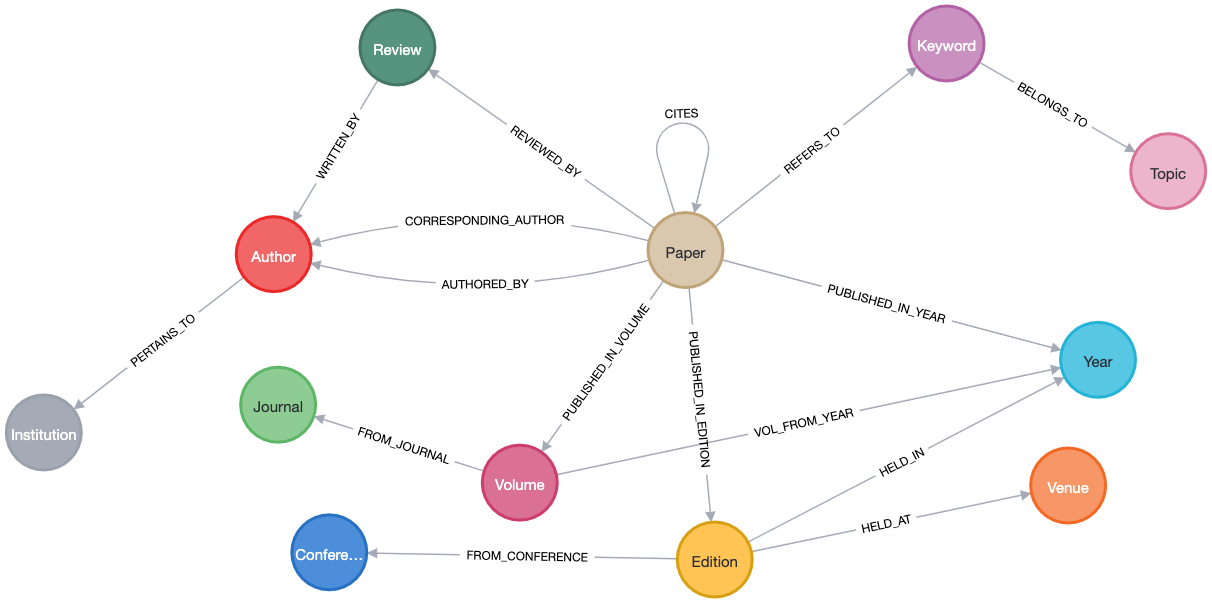

In [13]:
# img = Image.open('graphA3.png')
# background = Image.new('RGBA', img.size, (255, 255, 255, 255))
# background.paste(img, (0, 0), img)
# background = background.convert('RGB')
# background.save('graphA3_white_bg.png')

display(Image.open('graphA3_white_bg.png'))

### Cypher queries for modifications

In our case, we still have the database running in our computer with the configuration we established in the previous sections so we wanted to conceptualize our queries to modify the existing database instead of modifying the whole cypher code we had before and running everything again.

Please find below the implementation to tear apart the review relationships we had, substitute them with the node structure we devised and also add the new relationships between authors and their institutions.

In [14]:
def remove_existing_reviews(tx):
    tx.run("""
    MATCH (p:Paper)-[r:REVIEWED_BY]->(a:Author)
    DELETE r
    """)

def add_modifications(tx):
    # Load Reviews
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///node_reviews.csv' AS row
    MATCH (a:Author {author_name: row.reviewer_name})
    MATCH (p:Paper {DOI: row.paper_doi})
    CREATE (r:Review {review_id: row.review_id, review_content: row.content, review_decision: row.decision})
    CREATE (r)-[:WRITTEN_BY]->(a)
    CREATE (p)-[:REVIEWED_BY]->(r);
    """)
    
    # Load Institutions
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///institutions.csv' AS row
    CREATE (:Institution {institution_name: row.name});
    """)

    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///authors.csv' AS row
    MATCH (a:Author {author_name: row.name})
    MATCH (i:Institution {institution_name: row.affiliation})
    CREATE (a)-[:PERTAINS_TO]->(i);
    """)

with driver.session() as session:
    session.execute_write(remove_existing_reviews)
    session.execute_write(add_modifications)

print("Reviews added to Neo4j successfully.")

Reviews added to Neo4j successfully.


# QUERYING

[Back to Index](#INDEX)

## Query 1: Find the top 3 most cited papers of each conference.

[Back to Index](#INDEX)

### Explanation

#### Top 3 Most Cited Papers Query:

1. **Step 1**: Matches conferences with their editions and papers, and counts the citations for each paper.
2. **Step 2**: Orders papers by citation count and collects the top 3 papers for each conference.
3. **Step 3**: Unwinds the top papers and returns the conference name, paper title, paper DOI, and citation count, ordered by conference and citation count.

In [15]:
def query_top_cited_papers(tx):
    query = """
    // Step 1: Match conferences with their editions and papers
    MATCH (c:Conference)<-[:FROM_CONFERENCE]-(e:Edition)<-[:PUBLISHED_IN_EDITION]-(p:Paper)
    OPTIONAL MATCH (p)<-[:CITES]-(:Paper)
    WITH c, p, COUNT(p) AS citation_count

    // Step 2: Order papers by citation count and collect the top 3 papers for each conference
    ORDER BY c.conference_name, citation_count DESC
    WITH c, COLLECT({paper: p, citation_count: citation_count})[0..3] AS top_papers

    // Step 3: Unwind the top papers and return the results
    UNWIND top_papers AS paper_info
    RETURN c.conference_name AS conference, paper_info.paper.title AS paper_title, paper_info.paper.DOI AS paper_DOI, paper_info.citation_count AS citation_count
    ORDER BY conference, citation_count DESC
    """
    result = tx.run(query)
    return [{"conference": record["conference"], "paper_title": record["paper_title"], "paper_DOI": record["paper_DOI"], "citation_count": record["citation_count"]} for record in result]

with driver.session() as session:
    top_cited_papers = session.execute_read(query_top_cited_papers)


df_Q1 = pd.DataFrame(top_cited_papers, index = range(1, len(top_cited_papers)+1))
# display(df_Q1)

unique_confs = df_Q1['conference'].unique()

for conf in unique_confs:
    df_temp = df_Q1[df_Q1['conference'] ==  conf]
    df_temp.reset_index(drop = True, inplace = True)
    df_temp.index = df_temp.index + 1
    display(df_temp[['conference', 'paper_title', 'citation_count']])

# Print the results
# for paper in top_cited_papers:
#     print(f"Conference: {paper['conference']}, Paper Title: {paper['paper_title']}, DOI: {paper['paper_DOI']}, Citation Count: {paper['citation_count']}")

,conference,paper_title,citation_count
1,Conference of already,Reflect much deep fact.,21
2,Conference of already,Imagine good type audience affect letter.,15
3,Conference of already,Office president together benefit.,15


,conference,paper_title,citation_count
1,Conference of education,Agreement lose reduce goal sister throw.,18
2,Conference of education,Final total what mention tree main place.,18
3,Conference of education,From personal friend these not.,17


,conference,paper_title,citation_count
1,Conference of interview,Always star fly each gun news history.,18
2,Conference of interview,Three school sign hundred ability approach.,17
3,Conference of interview,Miss quite material size.,16


,conference,paper_title,citation_count
1,Conference of wait,Baby while former.,18
2,Conference of wait,Sister reason charge morning.,17
3,Conference of wait,The back last your himself.,17


,conference,paper_title,citation_count
1,Conference of we,Book growth herself site age major natural.,19
2,Conference of we,Likely create public various exactly dark kid.,18
3,Conference of we,Book degree it fill.,17


## Query 2: For each conference find its community: i.e., those authors that have published papers on that conference in, at least, 4 different editions.

[Back to Index](#INDEX)

### Explanation

#### Conference Community Query:

1. **Step 1**: Matches conferences with their editions, papers, and authors.
2. **Step 2**: Filters authors who have published in at least 4 different editions.
3. **Step 3**: Returns the conference name, author name, and edition count, ordered by conference and edition count.

In [16]:
def query_conference_communities(tx):
    query = """
    // Step 1: Match conferences with their editions, papers, and authors
    MATCH (c:Conference)<-[:FROM_CONFERENCE]-(e:Edition)<-[:PUBLISHED_IN_EDITION]-(p:Paper)-[:AUTHORED_BY]->(a:Author)
    WITH c, a, COUNT(DISTINCT e) AS edition_count

    // Step 2: Filter authors who have published in at least 4 different editions
    WHERE edition_count >=  4

    // Step 3: Return the conference name, author name, and edition count, ordered by conference and edition count
    RETURN c.conference_name AS conference, a.author_name AS author, edition_count
    ORDER BY conference, edition_count DESC, author
    """
    result = tx.run(query)
    return [{"conference": record["conference"], "author": record["author"], "edition_count": record["edition_count"]} for record in result]

with driver.session() as session:
    conference_communities = session.execute_read(query_conference_communities)

df_Q2 = pd.DataFrame(conference_communities)
# display(df_Q2)

unique_confs2 = df_Q2['conference'].unique()

for conf in unique_confs2:
    df_temp = df_Q2[df_Q2['conference'] ==  conf]
    df_temp.reset_index(drop = True, inplace = True)
    df_temp.index = df_temp.index + 1
    display(df_temp[['conference', 'author', 'edition_count']])

#for community in conference_communities:
#    print(f"Conference: {community['conference']}, Author: {community['author']}, Edition Count: {community['edition_count']}")

,conference,author,edition_count
1,Conference of already,Adam Harper,4
2,Conference of already,Amanda Brown,4
3,Conference of already,Brandon Santos,4


,conference,author,edition_count
1,Conference of education,Kimberly Pittman,7
2,Conference of education,Alyssa Taylor,6
3,Conference of education,Andrew Rodriguez,5
4,Conference of education,Beverly Dunn,5
5,Conference of education,Brad Harrison,5
6,Conference of education,Cindy Anderson,5
7,Conference of education,Erika Hoover,5
8,Conference of education,Heather Weiss,5
9,Conference of education,Jamie Mcdonald,5
10,Conference of education,Michael Chavez,5


,conference,author,edition_count
1,Conference of interview,Joan Atkins,4
2,Conference of interview,Lauren Schwartz,4
3,Conference of interview,Roger Mann,4


,conference,author,edition_count
1,Conference of wait,Andrew Rodriguez,4
2,Conference of wait,Ashley Montgomery,4
3,Conference of wait,Billy Wilkerson,4
4,Conference of wait,David Baker,4
5,Conference of wait,Gabriel Barnes,4
6,Conference of wait,Jason Davis,4
7,Conference of wait,Jeffrey Murphy,4
8,Conference of wait,Kara Reid,4
9,Conference of wait,Kelli Haas,4
10,Conference of wait,Kelly Franklin,4


,conference,author,edition_count
1,Conference of we,Annette Michael,4
2,Conference of we,Erin Smith,4
3,Conference of we,Hayley Morris,4
4,Conference of we,Mrs. Rachel Brown MD,4
5,Conference of we,Nicole Moran,4
6,Conference of we,Sergio Hawkins,4


## Query 3: Find the impact factors of the journals in your graph.

[Back to Index](#INDEX)

In any given year, the two-year journal impact factor is the ratio between the number of citations received in that year for publications in that journal that were published in the two preceding years and the total number of "citable items" published in that journal during the two preceding years:</br>
(Definition of the impact factor:, https://en.wikipedia.org/wiki/Impact_factor)</br>
 $$
\text{IF}_{y} = \frac{\text{Citations}_{y}}{\text{Publications}_{y-1} + \text{Publications}_{y-2}}
$$

### Explanation

#### Impact Factor Query:

1. **Step 1**: Matches journals with years and volumes, collecting unique pairs of journals and years.
2. **Step 2**: For each journal and year:
   - **Step 2.1**: Calculates the number of publications in the previous year.
   - **Step 2.2**: Calculates the number of publications in the year before the previous year.
   - **Step 2.3**: Calculates the number of citations in the current year for papers published in the previous two years.
   - **Step 2.4**: Calculates the impact factor if there are publications in both previous years.
3. **Step 3**: Collects and returns the results for all journals and years.
</br>

In [17]:
def query_journal_impact_factors(tx):
    query = """
    // Step 1: Identify all unique journals and years with corresponding volumes
    MATCH (y:Year)<-[:VOL_FROM_YEAR]-(v:Volume)-[:FROM_JOURNAL]->(j:Journal)
    WITH DISTINCT j, y.year AS year
    ORDER BY j.journal_name, year

    // Step 2: For each journal and year, attempt to calculate the impact factor
    CALL {
        WITH j, year
        
        // Step 2.1: Calculate publications in the previous year
        OPTIONAL MATCH (p1:Paper)-[:PUBLISHED_IN_VOLUME]->(v1:Volume)-[:FROM_JOURNAL]->(j)
        WHERE (v1)-[:VOL_FROM_YEAR]->(:Year {year: toString(toInteger(year) - 1)})
        WITH j, year, COUNT(p1) AS prev_year_publications

        // Step 2.2: Calculate publications in the year before the previous year
        OPTIONAL MATCH (p2:Paper)-[:PUBLISHED_IN_VOLUME]->(v2:Volume)-[:FROM_JOURNAL]->(j)
        WHERE (v2)-[:VOL_FROM_YEAR]->(:Year {year: toString(toInteger(year) - 2)})
        WITH j, year, prev_year_publications, COUNT(p2) AS prev_prev_year_publications

        // Step 2.3: Calculate citations in the current year for papers published in the previous two years
        OPTIONAL MATCH (p:Paper)-[:PUBLISHED_IN_VOLUME]->(v:Volume)-[:FROM_JOURNAL]->(j)
        WHERE (v)-[:VOL_FROM_YEAR]->(:Year {year: toString(toInteger(year) - 1)}) OR (v)-[:VOL_FROM_YEAR]->(:Year {year: toString(toInteger(year) - 2)})
        WITH j, year, prev_year_publications, prev_prev_year_publications, p
        OPTIONAL MATCH (citing_paper:Paper)-[:CITES]->(p)
        WHERE (citing_paper)-[:PUBLISHED_IN_VOLUME]->(:Volume)-[:VOL_FROM_YEAR]->(:Year {year: year})
        WITH j, year, prev_year_publications, prev_prev_year_publications, COUNT(citing_paper) AS citations_current_year

        // Step 2.4: Calculate impact factor if there are publications in both previous years
        RETURN year AS impact_year, j.journal_name AS journal,
            CASE WHEN citations_current_year = 0 THEN null ELSE citations_current_year END AS citations_current_year,
            CASE WHEN prev_year_publications = 0 THEN null ELSE prev_year_publications END AS prev_year_publications,
            CASE WHEN prev_prev_year_publications = 0 THEN null ELSE prev_prev_year_publications END AS prev_prev_year_publications,
            CASE
                WHEN prev_year_publications > 0 AND prev_prev_year_publications > 0
                THEN (citations_current_year * 1.0) / (prev_year_publications + prev_prev_year_publications)
                ELSE null
            END AS impact_factor
    }

    // Step 3: Collect results for all journals and years
    RETURN journal, impact_year AS year, prev_year_publications, prev_prev_year_publications, citations_current_year, impact_factor
    ORDER BY journal, year
    """
    result = tx.run(query)
    return [{"journal": record["journal"], "year": record["year"], "prev_year_publications": record["prev_year_publications"],
                "prev_prev_year_publications": record["prev_prev_year_publications"], "citations_current_year": record["citations_current_year"], "impact_factor": record["impact_factor"]} for record in result]


with driver.session() as session:
    journal_impact_factors = session.execute_read(query_journal_impact_factors)

df_Q3 = pd.DataFrame(journal_impact_factors)
# display(df_Q3)

unique_journals = df_Q3['journal'].unique() 

"""
NOTE: not all volumes will have an impact factor due to the fact that for the first two years we cannot compute it
due to not having any data for the previous two years. We can only compute the impact factor for the third year and posterior.
"""

for journal in unique_journals:
    df_temp = df_Q3[df_Q3['journal'] ==  journal]
    df_temp.reset_index(drop = True, inplace = True)
    df_temp.index = df_temp.index + 1
    display(df_temp[['journal', 'year', 'impact_factor']])

# in print format
#for record in journal_impact_factors:
#    print(f"Journal: {record['journal']}, Year: {record['year']}, Prev Year Publications: {record['prev_year_publications']}, Prev Prev Year Publications: {record['prev_prev_year_publications']}, Citations: {record['citations_current_year']}, Impact Factor: {record['impact_factor']}")

,journal,year,impact_factor
1,Journal of green,2013,NaN
2,Journal of green,2014,NaN
3,Journal of green,2015,0.340909
4,Journal of green,2016,0.590909
5,Journal of green,2017,0.386364
6,Journal of green,2018,0.422222


,journal,year,impact_factor
1,Journal of his,1995,NaN
2,Journal of his,1996,NaN
3,Journal of his,1997,0.177778
4,Journal of his,1998,0.227273


,journal,year,impact_factor
1,Journal of involve,2007,NaN
2,Journal of involve,2008,NaN
3,Journal of involve,2009,0.266667
4,Journal of involve,2010,0.113636
5,Journal of involve,2011,0.045455


,journal,year,impact_factor
1,Journal of work,2016,NaN
2,Journal of work,2017,NaN
3,Journal of work,2018,0.386364


## Query 4: Find the h-indexes of the authors in your graph.

[Back to Index](#INDEX)

The h-index is the largest number h such that h articles have at least h citations each. </br>

### h-index Definition and Formula

The h-index is defined as the maximum value of \( h \) such that the given author/journal has published at least \( h \) papers that have each been cited at least \( h \) times.

#### Calculation
(H-Index Definition:)https://en.wikipedia.org/wiki/H-index </br>

Formally, if \( f \) is the function that corresponds to the number of citations for each publication, we compute the h-index as follows:

$$
h\text{-index}(f) = \max \{ i \in \mathbb{N} : f(i) \geq i \}
$$

where \( f(i) \) is the number of citations for the \( i \)-th publication when ordered by the number of citations in descending order.

### Explanation

#### h-index Query:

1. **Step 1**: Matches authors with their papers and counts the citations for each paper.
2. **Step 2**: Collects the citation counts, sorts them, and calculates the h-index for each author based on the sorted citation counts.
</br>

In [18]:
def query_author_h_index(tx):
    query = """
    // Step 1: Retrieve the citation counts for each paper authored by each author
    MATCH (a:Author)<-[:AUTHORED_BY]-(p:Paper)
    OPTIONAL MATCH (p)<-[:CITES]-(citing:Paper)
    WITH a, p, COUNT(citing) AS citation_count

    // Step 2: Aggregate the citation counts and calculate the h-index for each author
    WITH a, COLLECT(citation_count) AS citation_counts
    UNWIND citation_counts AS citation
    WITH a, citation_counts, citation
    ORDER BY citation DESC
    WITH a, COLLECT(citation) AS sorted_citation_counts
    WITH a, [i IN RANGE(0, SIZE(sorted_citation_counts)-1) WHERE sorted_citation_counts[i] >=  i + 1 | i + 1] AS h_indices
    RETURN a.author_name AS author, LAST(h_indices) AS h_index
    ORDER BY h_index DESC
    """
    result = tx.run(query)
    return [{"author": record["author"], "h_index": record["h_index"]} for record in result]

with driver.session() as session:
    author_h_indices = session.execute_read(query_author_h_index)

df_Q4 = pd.DataFrame(author_h_indices)
display(df_Q4)

# print format
#for record in author_h_indices:
#    print(f"Author: {record['author']}, h-index: {record['h_index']}")


,author,h_index
0,Lori Wright,12
1,Anthony Clark,11
2,Annette Michael,11
3,John Clayton,11
4,Gabriel Barnes,11
...,...,...
195,William Gonzalez,7
196,Charles Madden,7
197,Derek Foster,7
198,Melissa Jones,7
